In [1]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
sys.path.insert(0,'../../scripts')

import pyccl as ccl
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count
import time
from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec

Ncm.cfg_init()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

initialize the `Cosmological model`

In [2]:
cosmo = Nc.HICosmo.new_from_name(Nc.HICosmo, "NcHICosmoDEXcdm")
reion = Nc.HIReionCamb.new () 

prim = Nc.HIPrimPowerLaw.new () 

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name('NcTransferFuncEH')

psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-3)
psml.require_kmax (1.0e3)
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

mulf = Nc.MultiplicityFuncBocquet.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
mulf.set_sim (Nc.MultiplicityFuncBocquetSim.DM)

hmf = Nc.HaloMassFunction.new (dist, psf, mulf)
hmf.set_area((0.0005)*np.pi)

#Creating the halo bias 
hbias_ps = Nc.HaloBiasTypePS()
mbiasf = Nc.HaloBiasFunc.new(hmf, hbias_ps)

# Define proxy modelling
Use a mass proxy, define the probability for observing a proxy given a mass and redhsift

$$
P(\log\lambda|M,z) = N(\mu(M,z), \sigma^2(M,z))
$$
the mean is
$$
    \mu(M,z) = \mu_0 + a_\mu^M\log_{10}\frac{M}{M_0} + a_\mu^z\log_{10}\frac{1+z}{1+z_0} 
$$
variance is
$$
\sigma(M,z) = \sigma_0 + a_\sigma^M\log_{10}\frac{M}{M_0} + a_\sigma ^z\log_{10}\frac{1+z}{1+z_0} 
$$

In [3]:
cluster_z = Nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0,2))
cluster_m = Nc.ClusterMass.new_from_name("NcClusterMassAscaso{'M0':<%20.15e>,'z0':<%20.15e>,'lnRichness-min':<%20.15e>, 'lnRichness-max':<%20.15e>}" % (3e14/(0.71),0.6, 0, np.log(10) * np.log10(10e6)))
cluster_m.param_set_by_name('mup0', 3.19)
cluster_m.param_set_by_name('mup1', 2/np.log(10))
cluster_m.param_set_by_name('mup2', -0.7/np.log(10))
cluster_m.param_set_by_name('sigmap0', 0.33)
cluster_m.param_set_by_name('sigmap1', -0.08/np.log(10))
cluster_m.param_set_by_name('sigmap2', 0/np.log(10))

Create the `Cluster Abundance Data`

In [4]:
ca = Nc.ClusterAbundance.new(hmf,mbiasf)
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])

#Generates cluster count catalog data


ncdata = Nc.DataClusterNCount.new(ca,'NcClusterRedshiftNodist','NcClusterMassAscaso')
rng = Ncm.RNG.pool_get("example_ca_sampling");
ncdata.init_from_sampling(mset,(0.0005)*np.pi,rng)
ncdata.catalog_save("ca_mean_bias_ascaso.fits", True)

ncdata_fits = fits.open('ca_mean_bias_ascaso.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort('Z_TRUE')
mset.pretty_log()


#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.36               [FIXED]
#   -     Omegac[01]:  0.2568              [FIXED]
#   -     Omegax[02]:  0.7                 [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0432              [FIXED]
#   -          w[07]: -1                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00]:  3.179               [FIXED]
#   - T_SA_ratio[01]:  0.2               

# Un-binned approach

$$
b_i = \int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M,z_i)}{d\log_{10}M}P(\lambda_i|M,z_i)b(M,z_i) d\log_{10}M
$$

In [7]:
display(ncdata_Table)
ca.prepare(cosmo,cluster_z,cluster_m)


print(ca.mean_bias(cosmo, cluster_z, cluster_m))
dnbias = []
for cluster in ncdata_Table:
    dnbias.append(ca.intp_d2n_bias(cosmo, cluster_z, cluster_m, [cluster[1]], None, [cluster[0]], None ))


display(dnbias)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.06995504829395446,0.9787360327553738,0.06995504829395446,31.082030869650588
0.08350670997616837,1.6422895444599972,0.08350670997616837,31.753855188773095
0.08758075309927918,1.954219370855404,0.08758075309927918,32.19291522623267
0.0969605107435312,1.0220202019128672,0.0969605107435312,31.071930326385534
0.10564334748414914,0.7020793355277206,0.10564334748414914,31.124717691071613
0.1068233309705027,0.9610714904929332,0.1068233309705027,30.008018812923613
0.11765674012388246,0.19760626356254804,0.11765674012388246,30.251392268706617
0.11914761034453737,0.08659748228875613,0.11914761034453737,30.54242622681923
0.12114714692400483,1.0135078651866318,0.12114714692400483,31.819603270087985


0.00045966451257437605


[0.00012589931162156892,
 7.61439288515797e-05,
 5.768809296226637e-05,
 0.00012281671479138546,
 0.00013936803174389369,
 0.0001271079202302469,
 0.00011146726691886666,
 9.623173531797236e-05,
 0.00012343519414609045,
 0.00013997088256667667,
 0.00013962042867976117,
 0.00012701924485515644,
 9.379635311330309e-06,
 0.00013997055250628842,
 0.0001399765830693903,
 9.323427649139024e-05,
 9.605795163543306e-05,
 8.077049141627664e-05,
 0.00013885047081140515,
 0.000123145011183783,
 0.00010787452570336261,
 0.00013384337409371174,
 0.00013625231406241435,
 0.00013798425785220501,
 0.00013979496258993202,
 0.00014015153774189608,
 4.139478656932939e-05,
 0.00013525221877849612,
 3.7155910845509564e-05,
 0.000124223045578044,
 0.0001327912468430043,
 6.32117017585396e-05,
 0.00013980791245722432,
 0.0001308504456312425,
 0.0001386738779012132,
 0.0001364552300887104,
 0.00013665733168939138,
 0.00010173760640923608,
 0.0001330838335662967,
 0.00012070843313719744,
 0.0001390507201272866

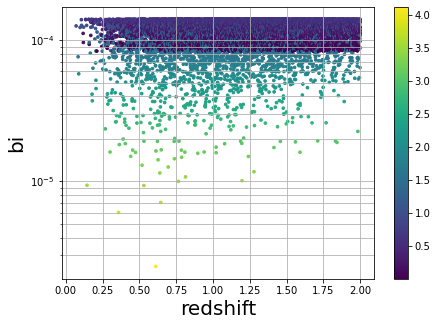

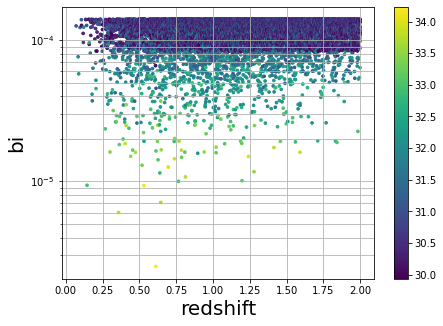

In [19]:
plt.figure(figsize = (7,5))
plt.scatter(ncdata_Table['Z_OBS'], dnbias ,s = 7, c = ncdata_Table['LNM_OBS'], cmap = 'viridis')
plt.colorbar()
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('bi', fontsize = 20)
plt.yscale('log')
plt.grid(True, which="both")
plt.show()


plt.figure(figsize = (7,5))
plt.scatter(ncdata_Table['Z_OBS'], dnbias ,s = 7, c = ncdata_Table['LNM_TRUE'], cmap = 'viridis')
plt.colorbar()
plt.xlabel('redshift', fontsize = 20)
plt.ylabel('bi', fontsize = 20)
plt.yscale('log')
plt.grid(True, which="both")
plt.show()

# Binned approach

Compute the integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}b(M,z)P(\lambda|M,z)d\log_{10}M
$$

In [20]:
#Bins definition
z_edges = np.linspace(0.25, 2, 10)
proxy_edges = np.linspace(0, 2, 4)

In [21]:
#Using Numcosmo

t0 = time.time()
ca.prepare(cosmo,cluster_z,cluster_m)
N_proxy_numcosmo = []


for rich_l, rich_u in zip(proxy_edges, proxy_edges[1:]):
    N_zbin = []
    for zl, zu in zip(z_edges,z_edges[1:]):
        N_zbin.append(ca.intp_bin_d2n_bias(cosmo,cluster_z,cluster_m, [rich_l], [rich_u],None ,[zl],[zu], None))
    
    N_proxy_numcosmo.append(N_zbin)

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

N_proxy_numcosmo

time (seconds) = 0.021382570266723633


[[1.8939082826096817e-05,
  2.0425193054869137e-05,
  2.1484650155983263e-05,
  2.1988378798747862e-05,
  2.186768131145544e-05,
  2.1123897243362864e-05,
  1.9823459894587043e-05,
  1.8082249738276904e-05,
  1.6044338220465528e-05],
 [1.6943365809739274e-05,
  1.716259326183553e-05,
  1.6957712325117786e-05,
  1.6277198003473098e-05,
  1.514508634703993e-05,
  1.3648331711559398e-05,
  1.191316701934743e-05,
  1.0078256383174034e-05,
  8.27131989287875e-06],
 [9.656992314994926e-06,
  9.276315621126691e-06,
  8.608965200159465e-06,
  7.687793874310028e-06,
  6.594441267968847e-06,
  5.432698738479266e-06,
  4.302159888261283e-06,
  3.2796425932845875e-06,
  2.41113277646464e-06]]

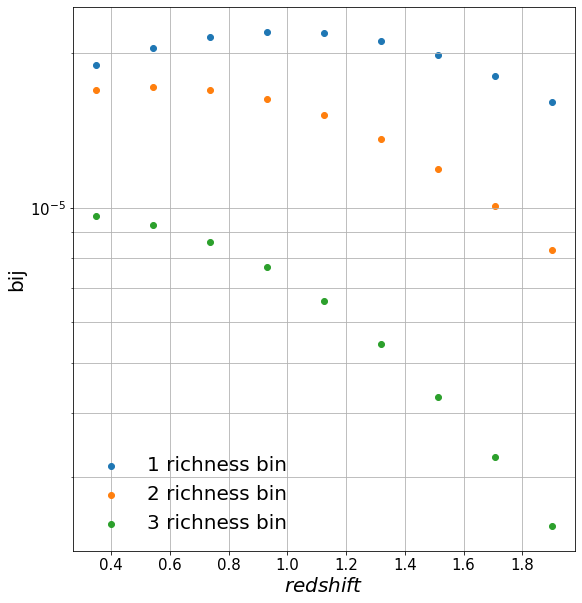

In [24]:
plt.figure(figsize = (9,10))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
proxy = [np.mean([proxy_edges[i],proxy_edges[i+1]]) for i in np.arange(len(proxy_edges)-1)]


plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(proxy_edges)-1):
    if f == 0:
        label = []
    y_simps = (N_proxy_numcosmo[:][f])
    plt.scatter(z_, y_simps, label = str(f+1)+' richness bin')
plt.grid(True, which="both" )
plt.ylabel('bij', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)